## ADCP analysis

In [1]:
%matplotlib notebook

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.integrate import cumtrapz
from scipy.signal import welch
from scipy.linalg import eig
import physoce.tseries as ts
import gsw

import datapath

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
ds = xr.open_dataset(datapath.adcpnc())
ds['height'] = ds['binheight'] + 0.4572 # add instrument height (18 inches)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (beam: 4, bin: 23, time: 98208)
Coordinates:
  * time       (time) datetime64[ns] 2017-11-10T10:03:13.760000 ... 2018-10-17T09:58:13.720000
Dimensions without coordinates: beam, bin
Data variables:
    Pit        (time) float64 ...
    Rol        (time) float64 ...
    Hea        (time) float64 ...
    Tem        (time) float64 ...
    Dep        (time) float64 ...
    Ori        (time) int64 ...
    BIT        (time) int64 ...
    Bat        (time) int64 ...
    Eas        (time, bin) float64 ...
    Nor        (time, bin) float64 ...
    Ver        (time, bin) float64 ...
    Err        (time, bin) float64 ...
    EA         (time, bin, beam) float64 ...
    PG         (time, bin, beam) float64 ...
    C          (time, bin, beam) float64 ...
    binheight  (bin) float64 2.14 3.14 4.14 5.14 ... 21.14 22.14 23.14 24.14
    Eas_filt   (time, bin) float64 ...
    Nor_filt   (time, bin) float64 ...
    height     (bin) float64 2.597 3.597 4.597 5.597 ... 2

### Basic time series plots

<IPython.core.display.Javascript object>


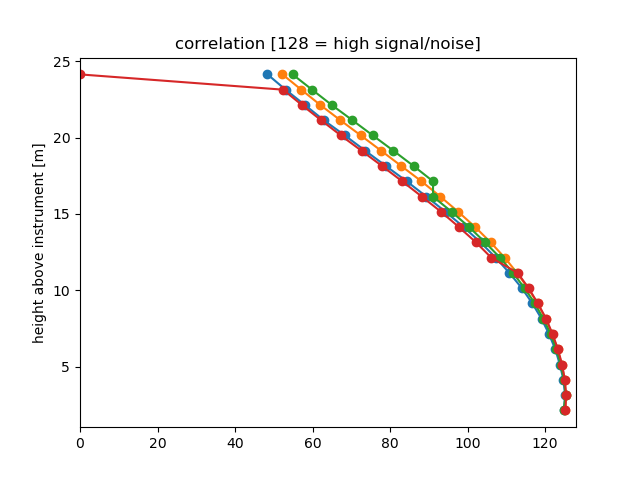

<IPython.core.display.Javascript object>


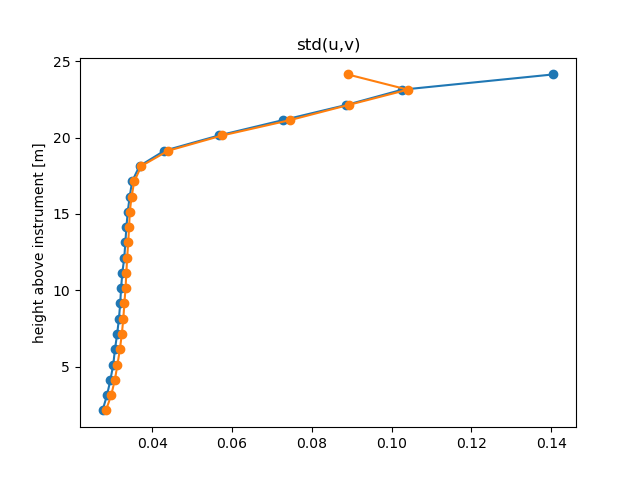

<IPython.core.display.Javascript object>


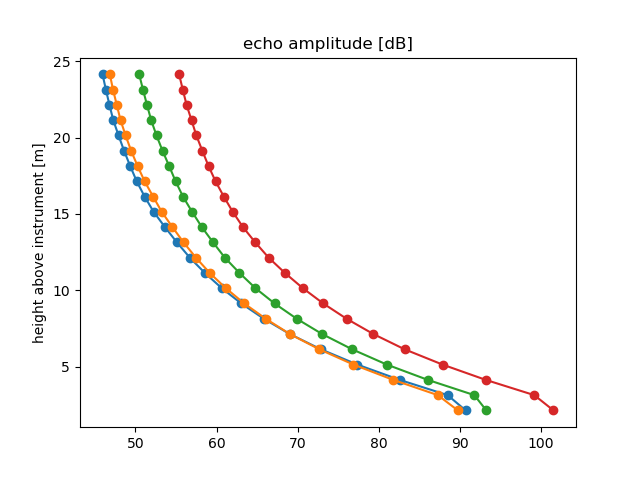

<IPython.core.display.Javascript object>


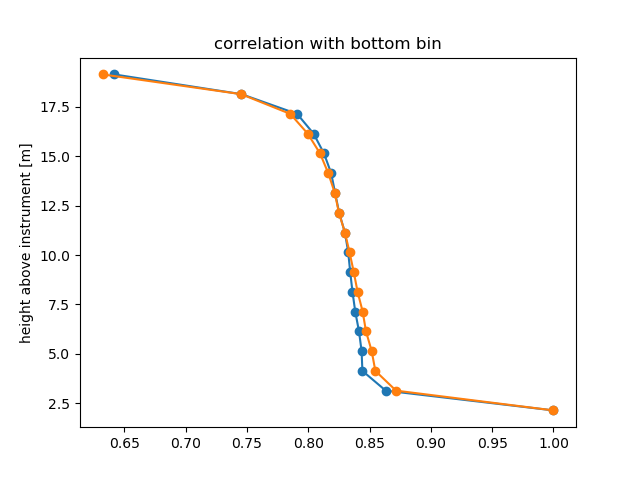

Text(0, 0.5, 'height above instrument [m]')

In [4]:
plt.figure()
plt.plot(np.mean(ds['C'],axis=0),ds['binheight'],'-o')
plt.title('correlation [128 = high signal/noise]')
plt.ylabel('height above instrument [m]')
plt.xlim([0,128])

plt.figure()
plt.plot(np.std(ds['Eas'],axis=0),ds['binheight'],'-o')
plt.plot(np.std(ds['Nor'],axis=0),ds['binheight'],'-o')
plt.title('std(u,v)')
plt.ylabel('height above instrument [m]')

plt.figure()
plt.plot(np.mean(ds['EA'],axis=0),ds['binheight'],'-o')
plt.title('echo amplitude [dB]')
plt.ylabel('height above instrument [m]')

plt.figure()
plt.plot(np.corrcoef(ds['Eas'],rowvar=False)[:,0],ds['binheight'],'-o')
plt.plot(np.corrcoef(ds['Nor'],rowvar=False)[:,0],ds['binheight'],'-o')
plt.title('correlation with bottom bin')
plt.ylabel('height above instrument [m]')

<IPython.core.display.Javascript object>


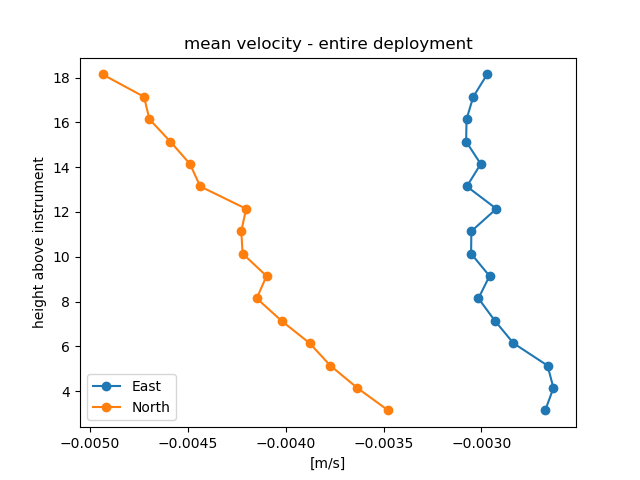

Text(0.5, 0, '[m/s]')

In [5]:
bini = np.arange(1,17)

plt.figure()
plt.plot(np.mean(ds['Eas'][:,bini],axis=0),ds['binheight'][bini],'-o')
plt.plot(np.mean(ds['Nor'][:,bini],axis=0),ds['binheight'][bini],'-o')
plt.title('mean velocity - entire deployment')
plt.legend(['East','North'])
plt.ylabel('height above instrument')
plt.xlabel('[m/s]')

In [6]:
dt = 5*60 # 5 min sample interval (in seconds)

x = cumtrapz(ds['Eas']*dt,axis=0)
y = cumtrapz(ds['Nor']*dt,axis=0)

<IPython.core.display.Javascript object>


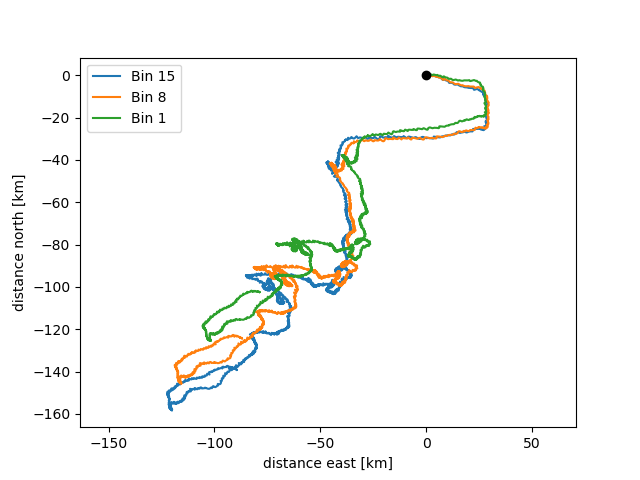

In [7]:
plt.figure()
plt.plot(x[:,15]/1000,y[:,15]/1000)
plt.plot(x[:,7]/1000,y[:,8]/1000)
plt.plot(x[:,1]/1000,y[:,1]/1000)
plt.plot(0,0,'ko')
plt.axis('equal')
plt.xlabel('distance east [km]')
plt.ylabel('distance north [km]')
plt.legend(['Bin 15','Bin 8','Bin 1'])

<IPython.core.display.Javascript object>


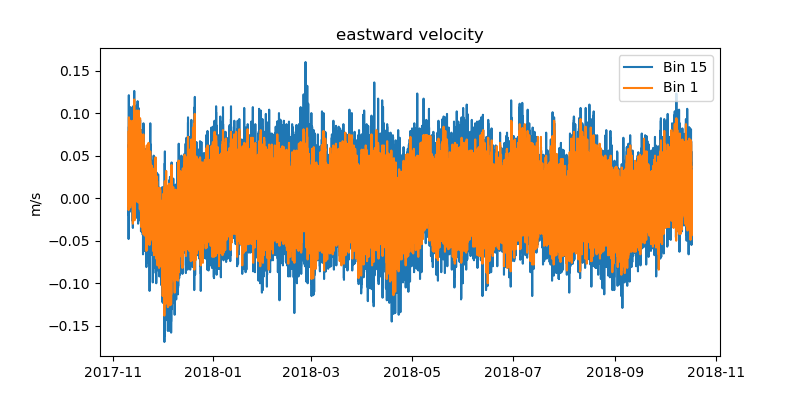

/Users/tomconnolly/programs/anaconda/envs/stationm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


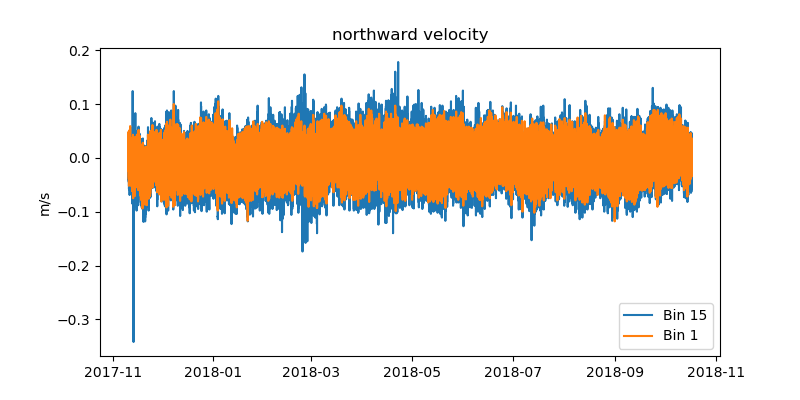

Text(0.5, 1.0, 'northward velocity')

In [8]:
plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas'][:,15]);
plt.plot(ds['time'],ds['Eas'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('eastward velocity')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Nor'][:,15]);
plt.plot(ds['time'],ds['Nor'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('northward velocity')

<IPython.core.display.Javascript object>


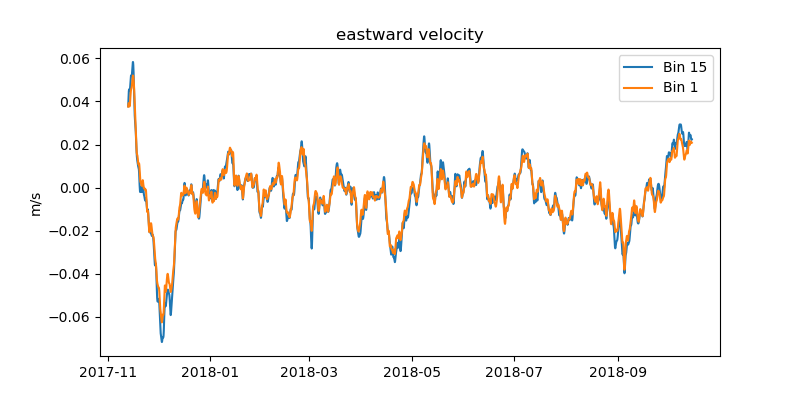

<IPython.core.display.Javascript object>


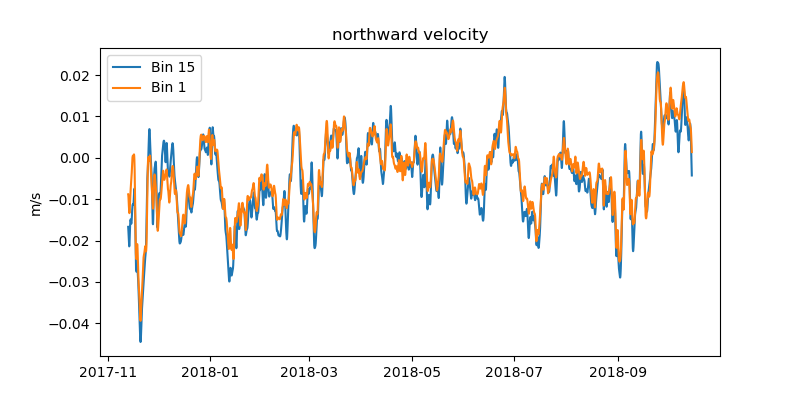

Text(0.5, 1.0, 'northward velocity')

In [9]:
plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas_filt'][:,15]);
plt.plot(ds['time'],ds['Eas_filt'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('eastward velocity')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Nor_filt'][:,15]);
plt.plot(ds['time'],ds['Nor_filt'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('northward velocity')

<IPython.core.display.Javascript object>


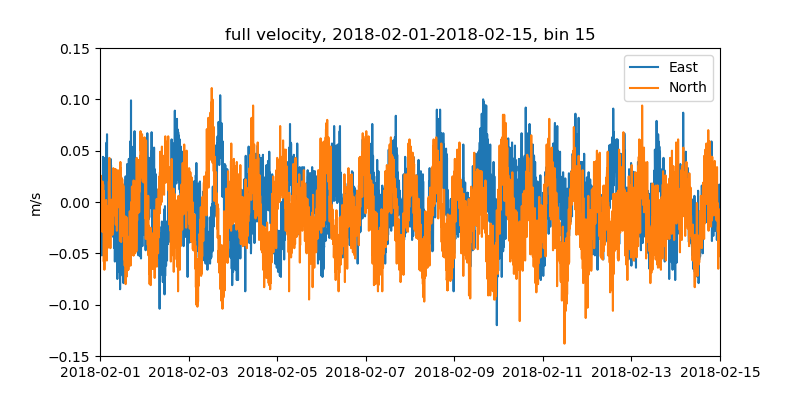

Text(0.5, 1.0, 'full velocity, 2018-02-01-2018-02-15, bin 15')

In [10]:
t1=np.datetime64('2018-02-01')
t2=np.datetime64('2018-02-15')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas'][:,15]);
plt.plot(ds['time'],ds['Nor'][:,15]);
plt.ylabel('m/s')
plt.xlim([t1,t2])
plt.ylim([-0.15,0.15])
plt.legend(['East','North'])
plt.title('full velocity, '+str(t1)+'-'+str(t2)+', bin 15')

### Rotary spectral analysis

In [11]:
Eas = np.array(ds['Eas'])
Nor = np.array(ds['Nor'])

N = len(Eas)
fE,SE = welch(Eas[:,5],fs=288.,nperseg=N/6,window='hanning')
fN,SN = welch(Nor[:,5],fs=288.,nperseg=N/6,window='hanning')

#rotary spectrum
fr,Sr = welch(Eas[:,0]+1j*Nor[:,0],
              fs=288.,nperseg=N/6,
              window='hann',return_onesided=False)
icw, = np.where(fr<0)
iccw, = np.where(fr>0)
fcw = -fr[icw]
Scw = Sr[icw]
fccw = fr[iccw]
Sccw = Sr[iccw]

In [12]:
# rotary coefficient
Cr = np.abs(Scw[1:]-Sccw[::-1])/(Scw[1:]+Sccw[::-1])
fr = fcw[1:]

In [13]:
f_cpd = gsw.f(35+8.4585/60)*86400/(2*np.pi)

# theoretical prediction (Van Haren and Millot (2004), eq. 11)
sigmar = 2*np.pi*fr
Cr_pred = 2*sigmar*(2*np.pi*f_cpd)/(sigmar**2 + (2*np.pi*f_cpd)**2)

<IPython.core.display.Javascript object>


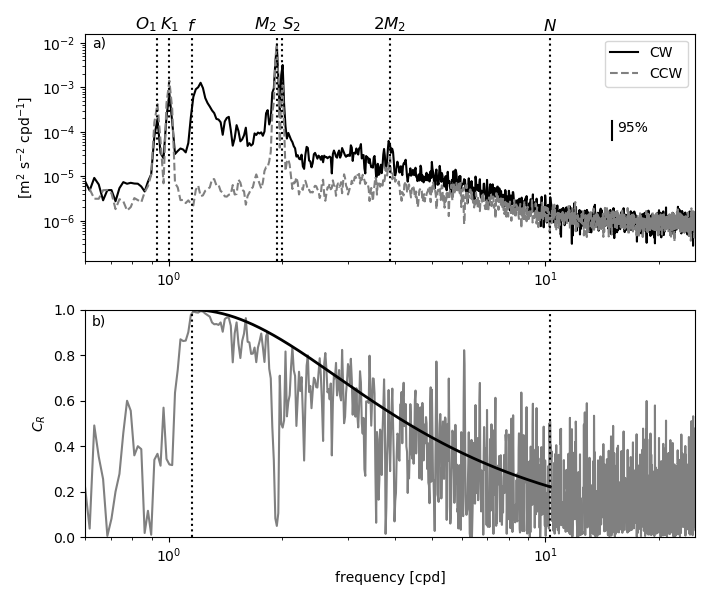

In [14]:
plt.figure(figsize=(7.1,6))
plt.subplot(211)
plt.loglog(fcw,Scw,'k-')
plt.loglog(fccw,Sccw,'--',color='gray')
plt.legend(['CW','CCW'])
#plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')


# confidence intervals
dof = 12
edof = (8/3)*dof
lower = edof/chi2.ppf(0.975,edof)
upper = edof/chi2.ppf(0.025,edof)
fplot = 15
fac = 0.0001
plt.plot(np.array([fplot,fplot]),fac*np.array([lower,upper]),'k-')
plt.text(fplot+0.5,fac*np.mean([lower,upper]),'95%',verticalalignment='center')

# buoyancy frequency
Nobs = 7.5e-4
bfrq_cpd = Nobs * 86400 / (2*np.pi) # observed N (cpd)


# plot frequencies
xl = [0.6,25]
yl = plt.ylim()
plt.plot([f_cpd,f_cpd],yl,':',color='k')
plt.plot([24/25.82,24/25.82],yl,':',color='k')
plt.plot([24/23.93,24/23.93],yl,':',color='k')
plt.plot([2,2],yl,':',color='k')
plt.plot([24/12.42,24/12.42],yl,':',color='k')
plt.plot([24/12.42*2,24/12.42*2],yl,':',color='k')
plt.plot([bfrq_cpd,bfrq_cpd],yl,':',color='k')
plt.ylim(yl)
plt.xlim(xl)

plt.text(f_cpd,yl[1],'$f$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(24/12.42,yl[1],'$M_2$',fontsize=12,
         horizontalalignment='right',
         verticalalignment='bottom')
plt.text(24/12.42*2,yl[1],'$2M_2$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(2,yl[1],'$S_2$',fontsize=12,
         horizontalalignment='left',
         verticalalignment='bottom')
plt.text(24/23.93,yl[1],'$K_1$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(24/25.82,yl[1],'$O_1$',fontsize=12,
         horizontalalignment='right',
         verticalalignment='bottom')
plt.text(bfrq_cpd,yl[1],'$N$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')

iwi, = np.where((fr >= f_cpd) & (fr <= bfrq_cpd))

xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.001*np.diff(xl),yl[1]-0.5*np.diff(yl),'a)')

plt.subplot(212)
plt.semilogx(fr,Cr,'gray')
plt.semilogx(fr[iwi],Cr_pred[iwi],'k-',lw=2)
yl = plt.ylim()
plt.semilogx([f_cpd,f_cpd],yl,'k:')
plt.xlabel('frequency [cpd]')
plt.ylabel('$C_R$')
#plt.title('rotary coefficients')
plt.ylim(yl)
plt.xlim(xl)
plt.ylim([0,1])

xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.001*np.diff(xl),yl[1]-0.07*np.diff(yl),'b)')
plt.plot([bfrq_cpd,bfrq_cpd],yl,':',color='k')

plt.tight_layout()

plt.savefig('figures_paper/rotary_spectrum_highfreq.pdf')
plt.savefig('figures_paper/rotary_spectrum_highfreq.png')

### Complex EOF/PCA

Show dominant mode of variability of low-pass filtered velocity.

First, express the velocity as a complex vector, $w$.

In [15]:
zi = np.arange(0,len(ds['height'])-7)

w = np.array(ds['Eas_filt'][:,zi])+1j*np.array(ds['Nor_filt'][:,zi])
fi, = np.where(np.isfinite(np.real(w[:,0])))

* Set up complex covariance matrix
* Calculate eigenvalues of covariance matrix

In [16]:
C = np.cov(w[fi,:],rowvar=False)
val,vec = eig(C)

Compute fraction of variance

In [17]:
np.abs(val)/np.sum(np.abs(val))

array([9.94328815e-01, 1.64222028e-03, 4.99373419e-04, 4.13714022e-04,
       3.64512559e-04, 1.60548027e-04, 1.76735500e-04, 3.33112456e-04,
       3.25335640e-04, 3.09040336e-04, 2.87253768e-04, 2.71581412e-04,
       2.11772372e-04, 2.01585892e-04, 2.39941191e-04, 2.34457973e-04])

<IPython.core.display.Javascript object>


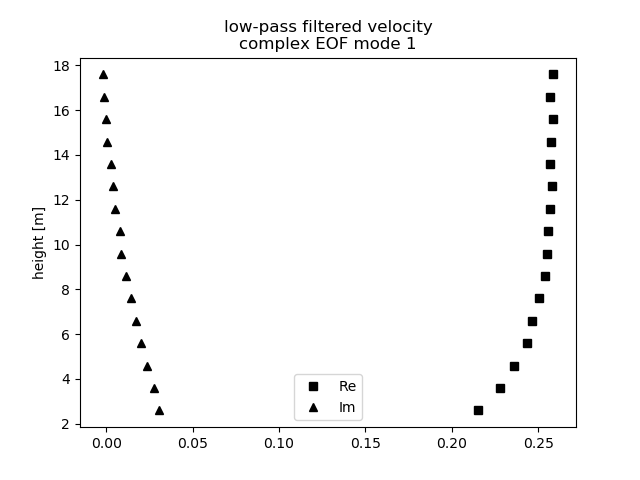

In [18]:
plt.figure()
plt.plot(np.real(vec[:,0]),ds['height'][zi],'ks')
plt.plot(np.imag(vec[:,0]),ds['height'][zi],'k^')
plt.title('low-pass filtered velocity\ncomplex EOF mode 1')
plt.ylabel('height [m]')
plt.legend(['Re','Im'])